## Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.


Spend up to 4 hours on this assignment. When you are done and have submitted a link to your notebook below, feel free to take a look at [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/2.solution_simple_linear_regression_models.ipynb).


In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


houseprices.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [2]:
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

The data set includes 1,460 observations with 81 features, some of which are missing some values, lets explore the data a little further below

In [3]:
houseprices.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


38 features have numerical values and 43 features have categorical values

### Missing Data

In [4]:
missing = houseprices.isnull().sum()/houseprices.isnull().count()
print(missing.sort_values(ascending=False))

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
lotfrontage      0.177397
garagecond       0.055479
garagetype       0.055479
garageyrblt      0.055479
garagefinish     0.055479
garagequal       0.055479
bsmtexposure     0.026027
bsmtfintype2     0.026027
bsmtfintype1     0.025342
bsmtcond         0.025342
bsmtqual         0.025342
masvnrarea       0.005479
masvnrtype       0.005479
electrical       0.000685
utilities        0.000000
yearremodadd     0.000000
mssubclass       0.000000
foundation       0.000000
extercond        0.000000
exterqual        0.000000
exterior2nd      0.000000
exterior1st      0.000000
roofmatl         0.000000
roofstyle        0.000000
yearbuilt        0.000000
                   ...   
garagearea       0.000000
paveddrive       0.000000
wooddecksf       0.000000
openporchsf      0.000000
threessnporch    0.000000
bsmtunfsf        0.000000
screenporch      0.000000
poolarea    

There are a lot of categorical features in this dataset, addtionally there are 19 features with some missing data. Prior to moving further lets find which features have the highest correlation to our target variable

### Data Cleaning

In [5]:
# Drop fields with greater than 10% missing data
houseprices = houseprices.drop(['poolqc', 'miscfeature', 'alley', 'fence','fireplacequ', 'lotfrontage'], axis=1)

#impute missing data with most frequent value (mode) for remaining missing data
houseprices = houseprices.apply(lambda x:x.fillna(x.value_counts().index[0]))

#check missing values
missing = houseprices.isnull().sum()/houseprices.isnull().count()
print(missing.sort_values(ascending=False))

saleprice        0.0
yearremodadd     0.0
roofmatl         0.0
exterior1st      0.0
exterior2nd      0.0
masvnrtype       0.0
masvnrarea       0.0
exterqual        0.0
extercond        0.0
foundation       0.0
bsmtqual         0.0
bsmtcond         0.0
bsmtexposure     0.0
bsmtfintype1     0.0
bsmtfinsf1       0.0
bsmtfintype2     0.0
bsmtfinsf2       0.0
roofstyle        0.0
yearbuilt        0.0
totalbsmtsf      0.0
overallcond      0.0
mssubclass       0.0
mszoning         0.0
lotarea          0.0
street           0.0
lotshape         0.0
landcontour      0.0
utilities        0.0
lotconfig        0.0
landslope        0.0
                ... 
wooddecksf       0.0
openporchsf      0.0
enclosedporch    0.0
threessnporch    0.0
screenporch      0.0
poolarea         0.0
miscval          0.0
mosold           0.0
yrsold           0.0
saletype         0.0
garagefinish     0.0
garagetype       0.0
heatingqc        0.0
fireplaces       0.0
centralair       0.0
electrical       0.0
firstflrsf   

### Exploratory Data Analysis and Feature Selection

In [6]:
# find highest correlation of numerical features with target variable
houseprice_corr = houseprices[houseprices.columns[1:]].corr()['saleprice'][:]
print(houseprice_corr.sort_values(ascending=False))

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.472614
fireplaces       0.466929
garageyrblt      0.397778
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64


There are several features with a strong correlation to saleprice, including 'overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'

Lets explore categorical features for correlation

In [7]:
# create a dataframe that holds only categorical features
cat_houseprices = houseprices.select_dtypes(include=['object']).copy()

In [8]:
cat_houseprices.head(10)

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,electrical,kitchenqual,functional,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
6,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
7,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
8,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,...,FuseF,TA,Min1,Detchd,Unf,Fa,TA,Y,WD,Abnorml
9,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,...,SBrkr,TA,Typ,Attchd,RFn,Gd,TA,Y,WD,Normal


In [9]:
# Use label encoder to convert categorical variables into numerical
cat_houseprices_label = cat_houseprices.apply(LabelEncoder().fit_transform)

#combine label encoded categorical data with saleprice to get correlation matrix
cat_houseprices_label['saleprice'] = houseprices['saleprice']

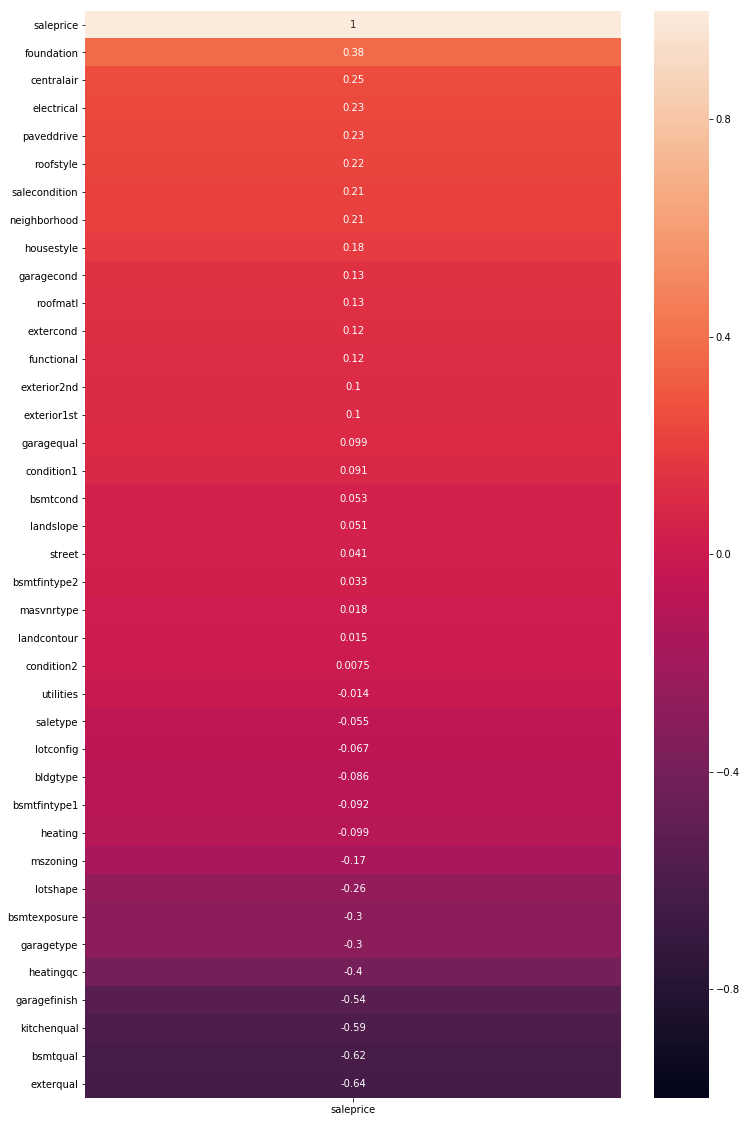

In [10]:
# plot heatmap correlation of label encoded categorical features
cat_houseprices_corr = cat_houseprices_label.corr()

plt.figure(figsize=(12,20))
sns.heatmap(cat_houseprices_corr[['saleprice']].sort_values(by=['saleprice'],ascending=False), vmin=-1,annot=True);

In addition to the numerical features correlated with saleprice there are also a few categorical features that have a strong correlation, including 'foundation', and 'centralair'

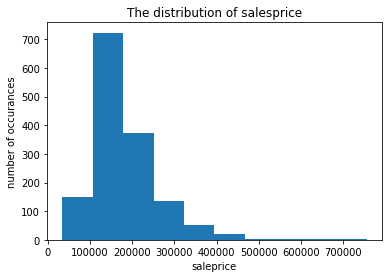

In [11]:
# explore distribution of target variable

plt.hist(houseprices.saleprice)
plt.title("The distribution of salesprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurances")
plt.show()

Our data is slightly skewed to the right with more occurances of salesprice from $150k-$200k

For this model we will select 6 numerical features and 2 categorical features that are highly correlated with saleprice

### Regression Model

In [12]:
# Build out dataframe with selected features

houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.foundation, prefix="foundation", drop_first=True)], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.centralair, prefix="centralair", drop_first=True)], axis=1)
dummy_col = list(pd.get_dummies(houseprices.foundation, prefix="foundation", drop_first=True).columns)
dummy_col = dummy_col + list(pd.get_dummies(houseprices.centralair, prefix="centralair", drop_first=True).columns)

In [13]:

X = houseprices[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'fullbath'] + dummy_col]
Y = houseprices.saleprice

In [14]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     398.8
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        07:28:14   Log-Likelihood:                -17478.
No. Observations:                1460   AIC:                         3.498e+04
Df Residuals:                    1447   BIC:                         3.505e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.078e+05   6343.394    -16.995      0.000    -1.2e+05   -9.54e+04
overallqual        2.187e+04   1183.004     18.487      0.000    1.95e+04    2.42e+04
grlivarea            48.2604      2.835     17.026      0.000      42.700      53.821
garagecars         1.232e+04   3055.293      4.031      0.000    6323.488    1.83e+04
garagearea           16.2194     10.430      1.555      0.120      -4.240      36.679
totalbsmtsf          31.6675      3.047     10.394      0.000      25.691      37.644
fullbath          -2072.6936   2604.845     -0.796      0.426   -7182.371    3036.984
foundation_CBlock  1.145e+04   3736.147      3.063      0.002    4116.568    1.88e+04
foundation_PConc   2.037e+04   4063.437      5.012      0.000    1.24e+04    2.83e+04
foundation_Slab    3.019e+04   8903.980      3.391      0.001    1.27e+04    4.77e+04
foundation_Stone    803.0377   1.61e+04      0.050      0.960   -3.07e+04    3.23e+04
foundation_Wood   -8784.9596   2.25e+04     -0.391      0.696   -5.29e+04    3.53e+04
centralair_Y       8597.4867   4506.508      1.908      0.057    -242.500    1.74e+04
==============================================================================
Omnibus:                      465.157   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50678.009
Skew:                          -0.403   Prob(JB):                         0.00
Kurtosis:                      31.852   Cond. No.                     4.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""